In [145]:
import altair as alt
from vega_datasets import data
import pandas as pd

# this line is necessary for the visualization to show up in jupyter notebook
alt.renderers.enable('notebook')

# as geodata we use a map of the United States at a resolution of 1:10.000.000, of which we extract the state borders
states = alt.topo_feature(data.us_10m.url, 'states')
# as data we want to visualize we use a dataset which contains 22.000 job postings on monster.com
# we cleaned the dataset in a different notebook - collapsed_data.csv contains the data on state level,
# with normalized data (data relative to state population) where appropriate
# cleaned_data contains all data points minus the ones where no location could be determined
source = '/home/vincent/Documents/programming/VisualizationFinalProject/jobsMap/src/dataset/us-jobs-on-monstercom/collapsed_data.csv'
source2 = '/home/vincent/Documents/programming/VisualizationFinalProject/jobsMap/src/dataset/us-jobs-on-monstercom/cleaned_data.csv'

In [146]:
'''
We can change the data we want to visualize by entering the names into the variable list.

Available data:

id                                      state id - not interesting
                                        but useful for brush & link
                                        
location
                                        state name - not interesting
                                        but useful for tooltips

total_jobs                              contains the amount of job postings
                                        in the dataset

total_jobs_rel                          contains the amount of job postings
                                        in the dataset in relation to
                                        state population
                                        (job postings per 100k capita)

other_job_types                         job offers that are neither
                                        full time nor part time

other_job_types_rel                     job offers that are neither
                                        full time nor part time
                                        in relation to state population
                                        (job postings per 100k capita)

fulltime_employees                      full time job offers as employee

fulltime_employees_rel                  full time job offers as employee
                                        in relation to state population
                                        (job postings per 100k capita)
                                        
fulltime_contractors                    full time job offers as contractor

fulltime_contractors_rel                full time job offers as contractor
                                        in relation to state population
                                        (job postings per 100k capita)

parttime_employees                      part time job offers as employee

parttime_employees_rel                  part time job offers as employee
                                        in relation to state population
                                        (job postings per 100k capita)

avg_yearly_salary_lower                 average lower bound of offered
                                        yearly salary in dollars

avg_yearly_salary_upper                 average upper bound of offered
                                        yearly salary in dollars

pseudo_avg_yearly_salary                contains an approximated
                                        average yearly salary.
                                        The dataset contains salary spans
                                        (from $x to $y), the pseudo average
                                        is the middle value between average
                                        lowest salary and average highest
                                        salary.

avg_hourly_wage_lower                   average lower bound of offered
                                        hourly wage in dollars

avg_yearly_salary_upper                 average upper bound of offered
                                        hourly wage in dollars

pseudo_avg_hourly_wage                  contains an approximated
                                        average hourly wage.
                                        The dataset contains wage spans
                                        (from $x to $y), the pseudo average
                                        is the middle value between average
                                        lowest wage and average highest
                                        wage.
'''

variable_list = ['total_jobs_rel', 'pseudo_avg_hourly_wage', 'pseudo_avg_yearly_salary']

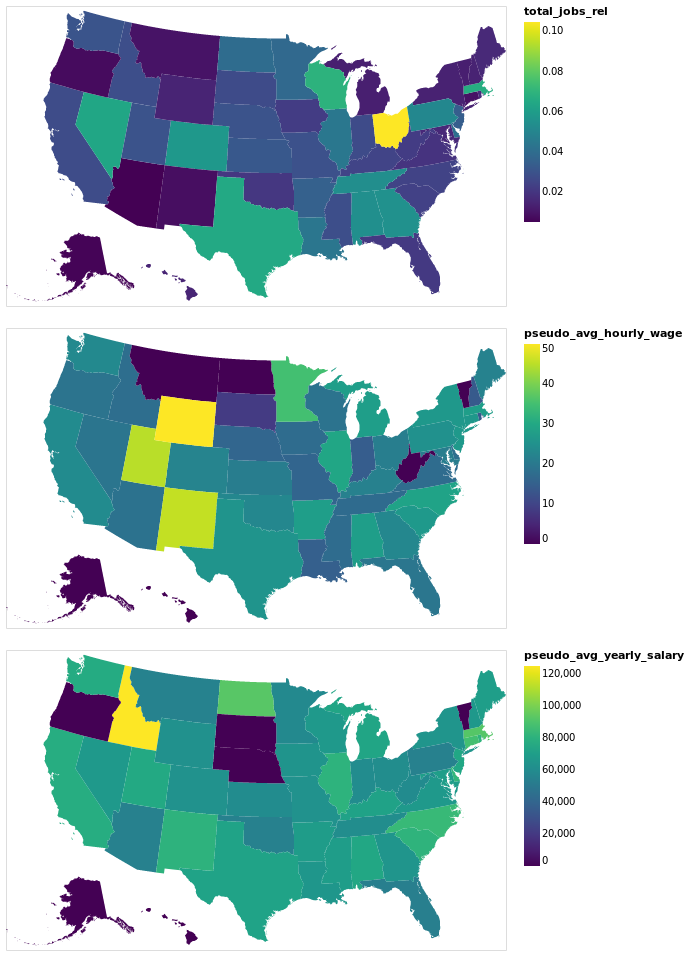

In [147]:

# loading the dataset into a pandas dataframe
data = pd.read_csv(source)
data2 = pd.read_csv(source2)

# enabling interaction with the map
# clicking and shift-clicking allows to select states on the map
click = alt.selection_multi()

# the visualization of the map
alt.Chart(states).mark_geoshape().encode(
    #If a state is clicked, highlight said state, shade all others gray
    
    #for default colours replace with this line:
    #color=alt.condition(click, alt.Color(alt.repeat('row'), type='quantitative'), alt.value('lightgray'))
    
    #the lecture mentions the importance of a good colour gradient for easy discernability of data.
    #we chose the gradient 'viridis', one of the recommended ones from the lecture
    color=alt.condition(click, alt.Color(alt.repeat('row'), scale=alt.Scale(scheme='viridis'), type='quantitative'), alt.value('lightgray'))
).transform_lookup(
    #binds the id of a state on the map to the corresponding id in our dataset
    lookup='id',
    from_=alt.LookupData(data, 'id', variable_list)
).properties(
    width=500,
    height=300
).project(
    type='albersUsa'
).repeat(
    row=variable_list
).resolve_scale(
    color='independent',
).add_selection(
    click
)

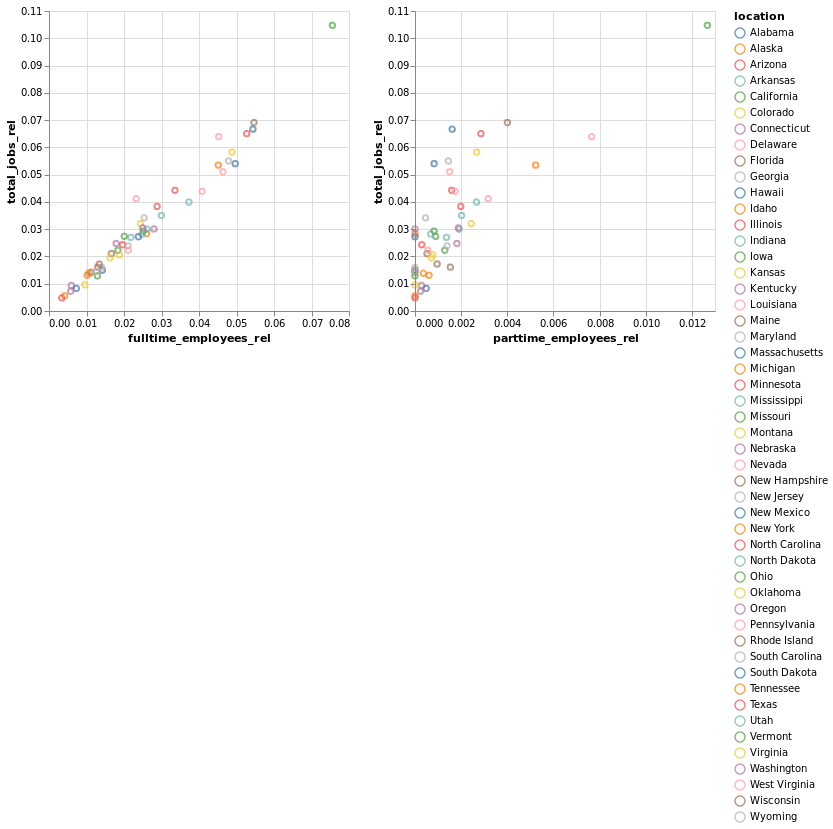

In [148]:
#enabling interaction with the scatter plot
#by clicking and dragging one can select data points in one plot, which get highlighted in the other plot
brush = alt.selection_interval()

#the visualization of the scatter plot
chart = alt.Chart(data).mark_point().encode(
    #the y-coordinte is identical in the two plots
    y='total_jobs_rel:Q',
    color=alt.condition(brush, 'location:N', alt.value('lightgray')),
    #hovering over a datapoint will show the name of the state as tooltip
    tooltip='location:N'
).properties(
    width=300,
    height=300
).add_selection(
    brush
)

#the x-coordinates of the two plots differ
#by declaring it this way, the selection of one value corresponds with the selection of the same value in the other plot
chart.encode(x='fulltime_employees_rel:Q') | chart.encode(x='parttime_employees_rel:Q')

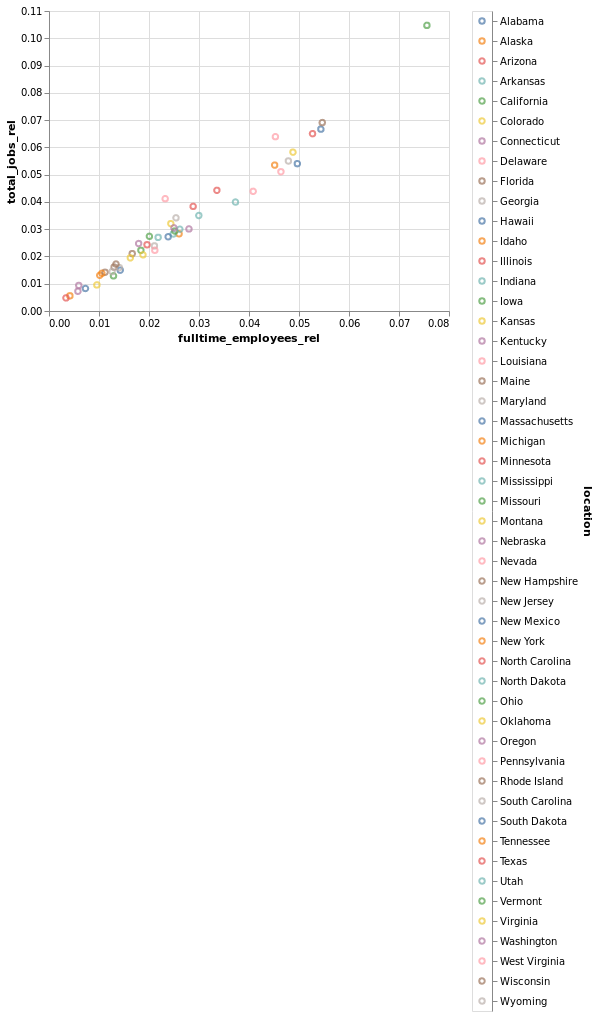

In [132]:
#enabling interaction with the legend of this scatter plot
selection = alt.selection_multi(fields=['location'])

#highlighting
color = alt.condition(selection,
                      alt.Color('location:N', legend=None),
                      alt.value('lightgray'))

#visualization of the scatterplot
scatter = alt.Chart(data).mark_point().encode(
    x='fulltime_employees_rel:Q',
    y='total_jobs_rel:Q',
    color=color,
    #datapoints show corresponding state as tooltip on mouseover
    tooltip='location:N'
).add_selection(
    #selecting states in the scatterplot by clicking and shift-clicking will highlight the corresponding points in the legend
    selection
)


#visualization of the legend
legend = alt.Chart(data).mark_point().encode(
    y=alt.Y('location:N', axis=alt.Axis(orient='right')),
    color=color
).add_selection(
    #selecting states in the legend by clicking and shift-clicking will highlight the corresponding points in the scatterplot
    selection
)

scatter | legend

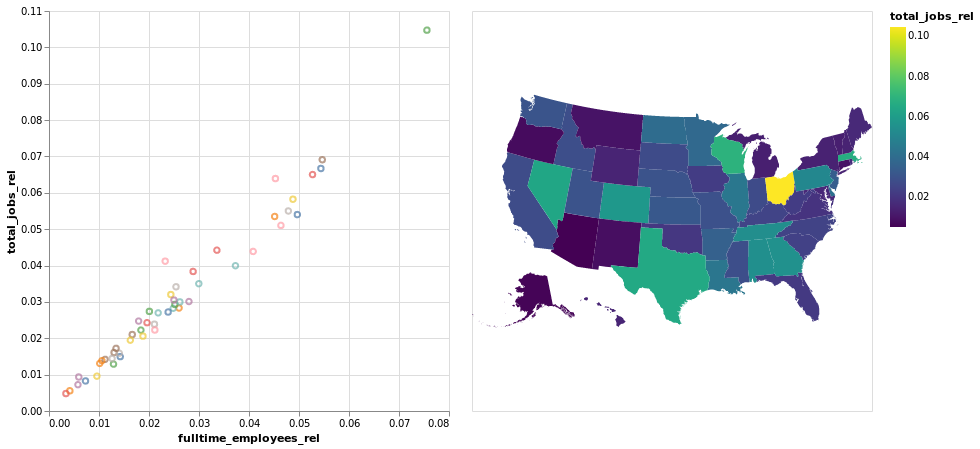

In [141]:
#enabling interaction for scatterplot and map
selection = alt.selection_multi(fields=['id'])

#highlighting
color = alt.condition(selection,
                      alt.Color('location:N', legend=None),
                      alt.value('lightgray'))

#visualization of the scatterplot
scatter = alt.Chart(data).mark_point().encode(
    x='fulltime_employees_rel:Q',
    y='total_jobs_rel:Q',
    color=color,
    tooltip='location:N'
).properties(
    width=400,
    height=400
).add_selection(
    #selecting states in the scatterplot by clicking and shift-clicking will highlight the corresponding points in the map
    selection
)


#which part of the dataset we want to visualize
variable_list = ['total_jobs_rel']

#visualization of the map
statemap = alt.Chart(states).mark_geoshape().encode(
    color=alt.condition(selection, alt.Color(alt.repeat('row'), scale=alt.Scale(scheme='viridis'), type='quantitative'), alt.value('lightgray')),
    tooltip='location:N'
).transform_lookup(
    lookup='id',
    from_=alt.LookupData(data, 'id', variable_list)
).properties(
    width=400,
    height=400
).project(
    type='albersUsa'
).repeat(
    row=variable_list
).resolve_scale(
    color='independent'
).add_selection(
    #selecting states in the map by clicking and shift-clicking will highlight the corresponding points in the scatterplot
    selection
)

scatter | statemap